# 光学画像の基礎分析1（雪判定）
このnotebookでは、光学画像の基礎的な分析として、雪のセグメンテーションを取り扱います。

***注意:***
* **このnotebookで取得する全てのデータはTellus上での利用に限定されます**
* **このnotebookで利用するTellus APIには一部サンプル目的のものが含まれます。これは予告なく変更される場合がございます。**
* **このnotebookでの分析の正確性については一切保証いたしません**

In [1]:
import numpy as np
from skimage import io
from skimage import color
from skimage import img_as_ubyte
from skimage import filters
import matplotlib.pyplot as plt
%matplotlib inline

## Tellusから光学画像の取得と前処理
富士山周辺の光学画像をTellusから取得します。今回はタイル化されたPNG形式のデータを扱います。位置の指定はXYZ方式を採用しています。詳細は [こちら（外部サイト）](https://maps.gsi.go.jp/development/siyou.html) をご覧ください。

詳細補足: ALOSという衛星のAVNIR-2と呼ばれるセンサから取得されたデータを扱います。AVNIR-2については [こちら（外部サイト）](https://www.eorc.jaxa.jp/ALOS/about/javnir2.htm) をご覧ください。

***注意:***
* **ここで利用しているAPIはサンプル目的のものです。Tellus Jupyter環境のみから利用できます。正式なAPIは今後追加される予定です。**

In [2]:
# APIのドメイン
URL_DOMAIN = "https://gisapi.opf-dev.jp/"

# 富士山の位置
Z = 13
X = 7252
Y = 3234

def get_data(img_type, domain=URL_DOMAIN, z=Z, x=X, y=Y):
    return io.imread("{}/{}/{}/{}/{}.png".format(domain, img_type, z, x, y))

img_osm = get_data("osm")
img_band1= get_data("av2ori/band1")
img_band2 = get_data("av2ori/band2")
img_band3 = get_data("av2ori/band3")
img_band4 = get_data("av2ori/band4")

### OpenStreetMapの確認

(256, 256, 3)


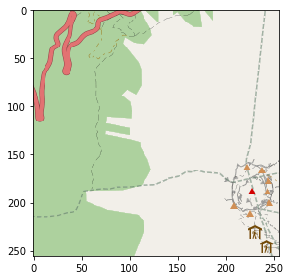

In [3]:
print(img_osm.shape)
io.imshow(img_osm)

### AVNIR-2の確認
AVNIR-2では4つの異なる波長のデータを利用できます。大まかに、Band1は青の波長、Band2は緑の波長、Band3は赤の波長、Band4は近赤外の波長に対応します。それぞれ単独で見ると以下のような画像になります。

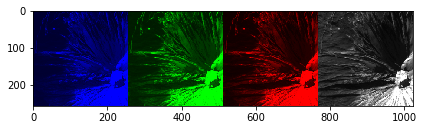

In [4]:
io.imshow(np.hstack((img_band1,img_band2,img_band3,img_band4)))

それぞれ可視光の青・緑・赤・（近赤外）に対応しているため、RGB（赤緑青）として1枚の画像に合成すると人の目で見た色に近いものになります。このようにして合成されたものtrue color画像と呼びます。

**true colorのRGB合成**
* R: Band3（赤）
* G: Band2（緑）
* B: Band1（青）

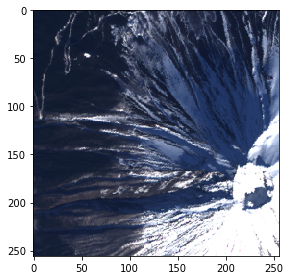

In [5]:
img_true = np.c_[img_band3[:,:,0:1], img_band2[:,:,1:2], img_band1[:,:,2:3]]
io.imshow(img_true)

true color以外にも合成方法はあり、例えば植生域だけを際立たせたい時は、植物の分布域が緑で表現されるnatural colorと呼ばれる合成が用いられます。これは、近赤外線は植物の反射率が高いことを利用し、RGBの赤に赤の波長であるBand3、緑に近赤外の波長であるBand4、青に緑の波長であるBand2を割り当てたものです。

**natural colorのRGB合成**
* R: Band3（赤）
* G: Band4（近赤外）
* B: Band2（緑）

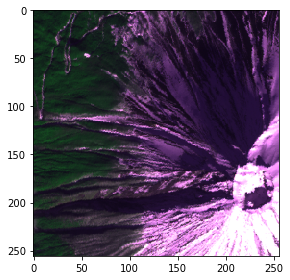

In [6]:
img_natural = np.c_[img_band3[:,:,0:1], img_band4[:,:,0:1], img_band2[:,:,1:2]]
io.imshow(img_natural)

## 直感的に白っぽいところを雪として判別してみる
ここでは、山の白っぽいところは雪なのでは？という直感に従って雪の抽出を行ってみます。true color画像を2つの方法でグレースケール化、更に閾値を決めて雪が抽出できるか検証してみましょう。

### グレースケール化による雪判定
#### グレースケール化①
`skimage.color.rgb2gray` を使って直接グレースケール化を試みます。

変換前: [0, 1]
[[ 0.10348667  0.10629216  0.09759294 ...,  0.13229098  0.4027102
   0.28838863]
 [ 0.10993098  0.10432     0.10712549 ...,  0.12278118  0.33378078
   0.18417294]
 [ 0.09675961  0.10320392  0.10684275 ...,  0.11662745  0.33016471
   0.21639373]
 ..., 
 [ 0.10853922  0.10825647  0.1090898  ...,  1.          1.          1.        ]
 [ 0.10714039  0.10825647  0.1090898  ...,  1.          1.          1.        ]
 [ 0.11189529  0.11441804  0.11189529 ...,  1.          1.          1.        ]]
変換後: [0, 255]
[[ 26  27  25 ...,  34 103  74]
 [ 28  27  27 ...,  31  85  47]
 [ 25  26  27 ...,  30  84  55]
 ..., 
 [ 28  28  28 ..., 255 255 255]
 [ 27  28  28 ..., 255 255 255]
 [ 29  29  29 ..., 255 255 255]]


/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


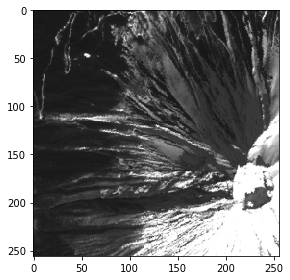

In [7]:
# カラー画像からGrayscale画像への変換
img_gray_01 = color.rgb2gray(img_true)

# 値のレンジを変更 ([0, 1] -> [0, 255])
img_gray = img_as_ubyte(img_gray_01) 

print("変換前: [0, 1]")
print(img_gray_01)
print("変換後: [0, 255]")
print(img_gray)

io.imshow(img_gray)

#### グレースケール化②
別のグレースケール化方法も試してみましょう。一度RGB空間からYIQ空間へ変換し、Yを利用を利用します。YIQ形式は、グレースケール情報がカラーデータから分離しているため、同じ信号をカラーと白黒の両方で使用可能です。

（※ グレースケール化のアルゴリズムによっては `img_gray_01` と `img_yiq[:, :, 0]` が等しくなりますが、skimageでは異なります）

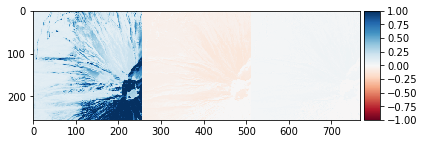

In [8]:
img_yiq = color.rgb2yiq(img_true)
img_conb = np.concatenate(
    (img_yiq[:, :, 0], img_yiq[:, :, 1], img_yiq[:, :, 2]), axis=1)
io.imshow(img_conb)

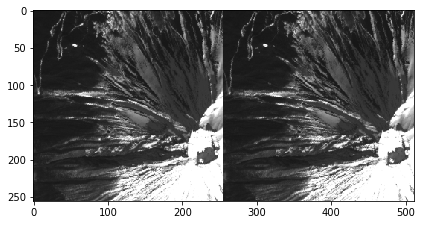

In [9]:
# skimage.color.rgb2gray と比較
img_conb2 = np.concatenate((img_yiq[:, :, 0], img_gray_01), axis=1)
io.imshow(img_conb2)

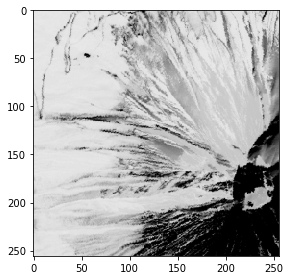

In [10]:
# 反転画像も確認
img_nega = 255 - img_gray
io.imshow(img_nega)

#### グレースケール化されたデータの統計情報の確認

In [11]:
print('pixel sum', np.sum(img_gray[:, :]))
print('pixel mean', np.mean(img_gray[:,:]))
print('pixel variance', np.var(img_gray[:,:]))
print('pixel stddev', np.std(img_gray[:,:]))

pixel sum 5346313
pixel mean 81.5782623291
pixel variance 5034.10730885
pixel stddev 70.9514433176


#### ヒストグラムの確認

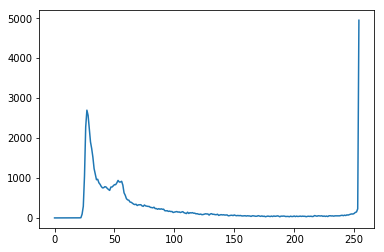

In [12]:
hists, bins = np.histogram(img_gray, 255, [0, 255])
plt.plot(hists)

明らかなピークは3箇所で `25` と `55` と `250` 付近と分かります。
`25〜55` は暗めなので森や岩、`250~255` はほぼ白なので雪と推定することができます。

#### 閾値を決めて雪と思われる部分を抽出
谷の一番深い位置と思われる `200` を閾値として2値化を行います。

/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


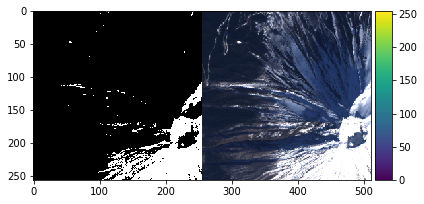

In [13]:
# 閾値処理
height, width= img_gray.shape
img_binary_gs200 = np.zeros((height, width)) # 0で初期化
img_binary_gs200 = img_gray > 200 # 閾値にもとづいて2値化

io.imshow(np.concatenate(
    (color.gray2rgb(img_binary_gs200*255), img_true), axis=1))

一番明るいところは抽出できているものの、日陰の雪と思われる部分は全く抽出できていないようです。閾値を `80` に変更して再度2値化を行います。

/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


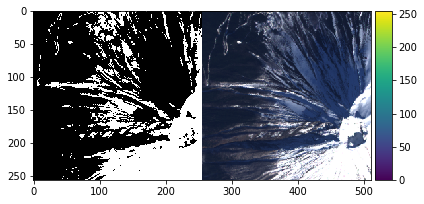

In [14]:
img_binary_gs80 = np.zeros((height, width)) # 0で初期化
img_binary_gs80 = img_gray > 80 # 閾値にもとづいて2値化

io.imshow(np.concatenate(
    (color.gray2rgb(img_binary_gs80*255), img_true), axis=1))

雪と思われる部分をそれなりに抽出できたように見えますが、まだ右上の部分が抽出できていないため、再度閾値を `40` に下げて2値化を行ってみます。

/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


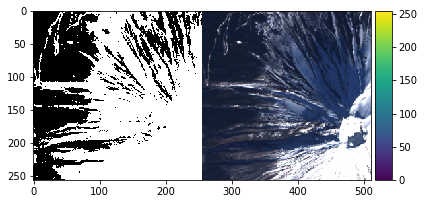

In [15]:
img_binary_gs40 = np.zeros((height, width)) # 0で初期化
img_binary_gs40 = img_gray > 40 # 閾値にもとづいて2値化

io.imshow(np.concatenate(
    (color.gray2rgb(img_binary_gs40*255), img_true), axis=1))

今度は範囲を過剰に取ってしまったようです。

なお、Filterプラグインを用いることで、自動で閾値を設定して2値化することもできます。

閾値： 138


/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


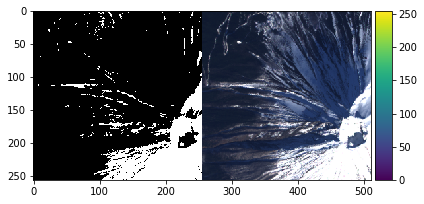

In [16]:
th = filters.threshold_otsu(img_gray) # 閾値を自動で判別
img_binary_gsauto = np.zeros((height, width))
img_binary_gsauto = img_gray > th

print("閾値：", th)
io.imshow(np.concatenate(
    (color.gray2rgb(img_binary_gsauto*255), img_true), axis=1))

### HSV画像による雪質判定
よりよいセグメンテーションを行うにはグレースケール以外の手法も試す必要がありそうです。次はHSV空間（色相・彩度・明度）に変換した画像を利用して雪の範囲を推定してみます。

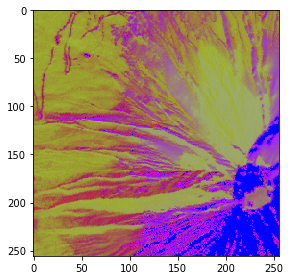

In [17]:
# RGB空間からHSV空間へ変換
img_hsv = color.rgb2hsv(img_true)
io.imshow(img_hsv)

#### HSV（色相・彩度・明度）をそれぞれ確認

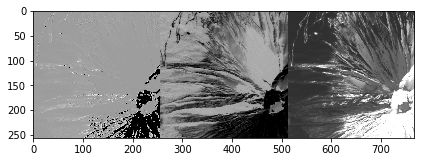

In [18]:
im_conb_hsv = np.concatenate(( img_hsv[:, :, 0],  img_hsv[:, :, 1], img_hsv[:,:,2]), axis=1)
io.imshow(im_conb_hsv)

明度を掘り下げてみます。ヒストグラムで明度の分布を確認します。

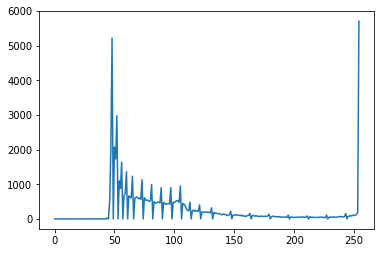

In [19]:
hists, bins=np.histogram(img_hsv[:,:,2]*255, 255, [0, 255])
plt.plot(hists)

 `color.rgb2hsv` の利用に起因すると思われる周期が見られます。ピークを分けるよう閾値を `150` に設定し、2値画像を見てみます。

/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


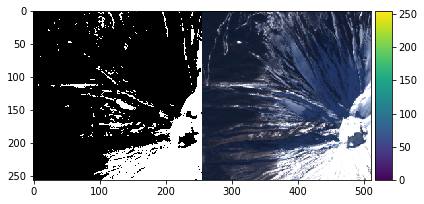

In [20]:
img_v = img_hsv[:,:,2]
# 閾値処理
height, width= img_v.shape
img_binary_v150 = np.zeros((height, width)) # 0で初期化
img_binary_v150 = img_v > 150 / 255 # 閾値にもとづいて2値化

io.imshow(np.concatenate(
    (color.gray2rgb(img_binary_v150*255), img_true), axis=1))

`100` のピークの左側に閾値を設定すべく、閾値を `90` にして再度2値化を行ってみます。

/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


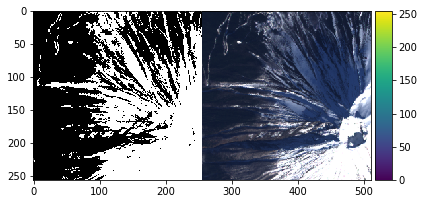

In [21]:
img_v = img_hsv[:,:,2]
# 閾値処理
height, width= img_v.shape
img_binary_v90 = np.zeros((height, width)) # 0で初期化
img_binary_v90 = img_v > 90 / 255 # 閾値にもとづいて2値化

io.imshow(np.concatenate(
    (color.gray2rgb(img_binary_v90*255), img_true), axis=1))

### RGBグレースケール化に基づく手法と明度に基づく手法の比較

/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


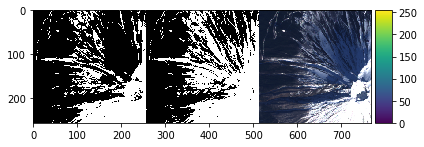

In [22]:
io.imshow(np.concatenate(
    (color.gray2rgb(img_binary_gs80*255),
     color.gray2rgb(img_binary_v90*255),
     img_true), axis=1))

明度に基づく手法はグレースケール化に基づく手法と比較して、日陰になった部分も含めて雪判定ができたようです。

更に異なる手法も考えられますが、雪判定はここまでとします。